In [699]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Read CSV File

In [700]:
df = pd.read_csv('cleaned_data.csv')
result_df = pd.DataFrame()

# DataFrame to np.array

In [701]:
targetValue = 'Nottingham prognostic index'

In [702]:
features = df.drop([targetValue, 'Patient ID'], axis=1).values
target = df[targetValue].values

# Train,Test,Split

In [703]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Linear Regression

In [704]:
LR_model = LinearRegression()
LR_model.fit(x_train, y_train)

LinearRegression()

In [705]:
y_pred = LR_model.predict(x_test).astype('float64')
# y_pred = np.round(y_pred).astype('int64')
result_df = result_df.assign(test=y_test, LR_pred=y_pred)

In [706]:
# matching_rows = (result_df['test'] == result_df['LR_pred']).sum()
print(f"تعداد ردیف‌ها: {result_df.shape[0]}")
# print(f"تعداد ردیف‌هایی که مقادیر برابر دارند: {matching_rows}")


تعداد ردیف‌ها: 502


# Decision Tree

In [707]:
DT_model = tree.DecisionTreeRegressor(min_samples_leaf=3, random_state=42)
DT_model.fit(x_train, y_train)

DecisionTreeRegressor(min_samples_leaf=3, random_state=42)

In [708]:
y_pred = DT_model.predict(x_test).astype('float64')
# y_pred = np.round(y_pred).astype('int64')
result_df = result_df.assign(DT_pred=y_pred)

In [709]:
# matching_rows = (result_df['test'] == result_df['DT_pred']).sum()
# print(f"تعداد ردیف‌هایی که مقادیر برابر دارند: {matching_rows}")

# Random Forest

In [710]:
RF_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
RF_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=20, random_state=42)

In [711]:
y_pred = RF_model.predict(x_test).astype('float64')
# y_pred = np.round(y_pred).astype('int64')
result_df = result_df.assign(RF_pred=y_pred)

In [712]:
# matching_rows = (result_df['test'] == result_df['RF_pred']).sum()
# print(f"تعداد ردیف‌هایی که مقادیر برابر دارند: {matching_rows}")

In [713]:
result_df = result_df.assign(survival=df['Overall Survival Status'])
result_df = result_df[result_df['survival'] != 0]
print(result_df.shape[0])
result_df.sample(10)

498


,test,LR_pred,DT_pred,RF_pred,survival
344,4.024,4.209387,4.024000,3.914448,1
257,3.036,3.385040,3.036000,3.035964,1
101,2.054,2.886743,2.050000,2.055640,1
386,3.068,3.202572,3.066500,3.068685,1
197,2.080,1.895268,2.091533,2.101834,1
422,2.040,1.559389,1.073333,1.184100,2
293,6.002,5.885031,6.000000,5.949580,1
385,6.060,5.159248,6.060000,6.059300,1
382,4.030,3.879084,4.030000,4.029988,1
31,0.000,1.047908,0.635000,0.791360,1


## Confusion Matrix

In [714]:
def my_confusion_matrix(y_test, y_pred, num_classes):
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(num_classes):
        for j in range(num_classes):
            conf_matrix[i, j] = np.sum((y_test == i) & (y_pred == j))

    return conf_matrix

def metrics(conf_matrix):
    num_classes = len(conf_matrix)
    results = {}

    for i in range(num_classes):
        true_positive = conf_matrix[i, i]
        true_negative = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
        false_positive = np.sum(conf_matrix[:, i]) - true_positive
        false_negative = np.sum(conf_matrix[i, :]) - true_positive

        total = true_positive + true_negative + false_positive + false_negative
        positives = true_positive + false_negative
        negatives = true_negative + false_positive

        sensitivity = true_positive / positives if positives > 0 else 0  # Recall
        specificity = true_negative / negatives if negatives > 0 else 0
        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0

        results[f'Class {i}'] = {
            'TP': true_positive,
            'TN': true_negative,
            'FP': false_positive,
            'FN': false_negative,
            'Total': total,
            'Positives': positives,
            'Negatives': negatives,
            'Sensitivity(Recall)': sensitivity,
            'Specificity': specificity,
            'Precision': precision
        }

    return results

In [715]:
def confusion_matrix(y_test_class_items, y_pred_class_items):
    tp = np.sum((y_test_class_items == 1) & (y_pred_class_items == 1))
    tn = np.sum((y_test_class_items == 2) & (y_pred_class_items == 2))
    fp = np.sum((y_test_class_items == 2) & (y_pred_class_items == 1))
    fn = np.sum((y_test_class_items == 1) & (y_pred_class_items == 2))
    return tp, tn, fp, fn

def roc_curve_scratch(y_test, y_predict, target):
    thresholds = np.linspace(np.min(target), np.max(target), 498)
    roc_fp_rate, roc_rp_rate = [], []
    auc_value = 0.0
    for item in thresholds:
        y_pred = np.where(y_predict >= item, 2, 1)
        thresholds_tp, thresholds_tn, thresholds_fp, thresholds_fn = confusion_matrix(y_test, y_pred)
        tpr_value = thresholds_tp / (thresholds_tp + thresholds_fn)
        fpr_value = thresholds_fp / (thresholds_fp + thresholds_tn)
        roc_rp_rate.append(tpr_value)
        roc_fp_rate.append(fpr_value)

    for i in range(1, len(thresholds)):
        y_pred_high = np.where(y_predict >= thresholds[i], 2, 1)
        y_pred_low = np.where(y_predict >= thresholds[i - 1], 2, 1)
        tp_high, tn_high, fp_high, fn_high = confusion_matrix(y_test, y_pred_high)
        tp_low, tn_low, fp_low, fn_low = confusion_matrix(y_test, y_pred_low)
        tpr_high = tp_high / (tp_high + fn_high)
        fpr_high = fp_high / (fp_high + tn_high)
        tpr_low = tp_low / (tp_low + fn_low)
        fpr_low = fp_low / (fp_low + tn_low)
        auc_value += 0.5 * (tpr_high + tpr_low) * (fpr_low - fpr_high)

    roc_fp_rate[0] = 1
    roc_fp_rate[-1] = 0
    roc_rp_rate[0] = 1
    roc_rp_rate[-1] = 0
    return roc_fp_rate, roc_rp_rate, thresholds, auc_value

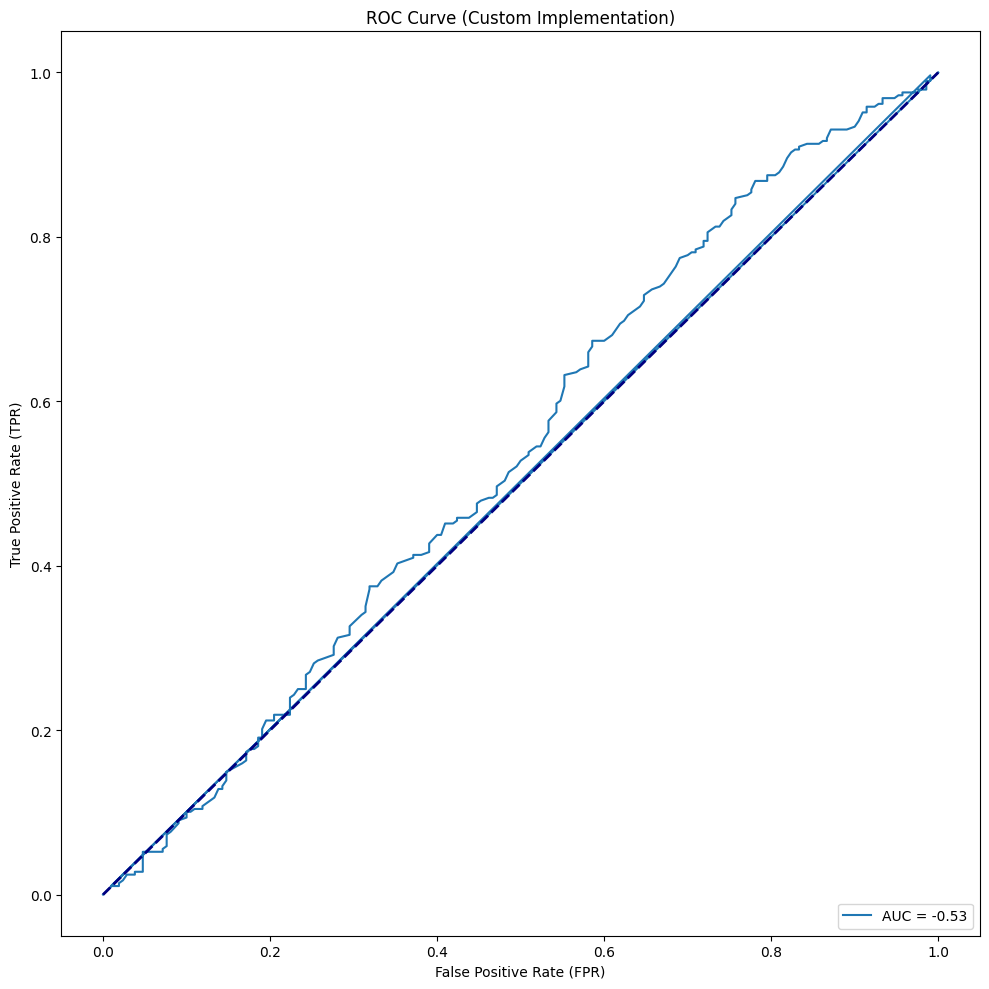

In [717]:
thresholds_tp, thresholds_tn, thresholds_fp, thresholds_fn = confusion_matrix(result_df['LR_pred'], result_df['survival'])
roc_fpr, roc_tpr, thresholds, auc_value = roc_curve_scratch(result_df['survival'], result_df['LR_pred'], result_df['test'])
def roc_curve_graph(roc_fpr, roc_tpr, auc_value, save_path='roc_curves.jpg'):
    plt.figure(figsize=(10, 10))
    plt.plot(roc_fpr, roc_tpr, label=f'AUC = {auc_value:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('ROC Curve (Custom Implementation)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(save_path, format='jpg', bbox_inches='tight', pad_inches=0)
    plt.show()
roc_curve_graph(roc_fpr, roc_tpr, auc_value)

0 0 0 1


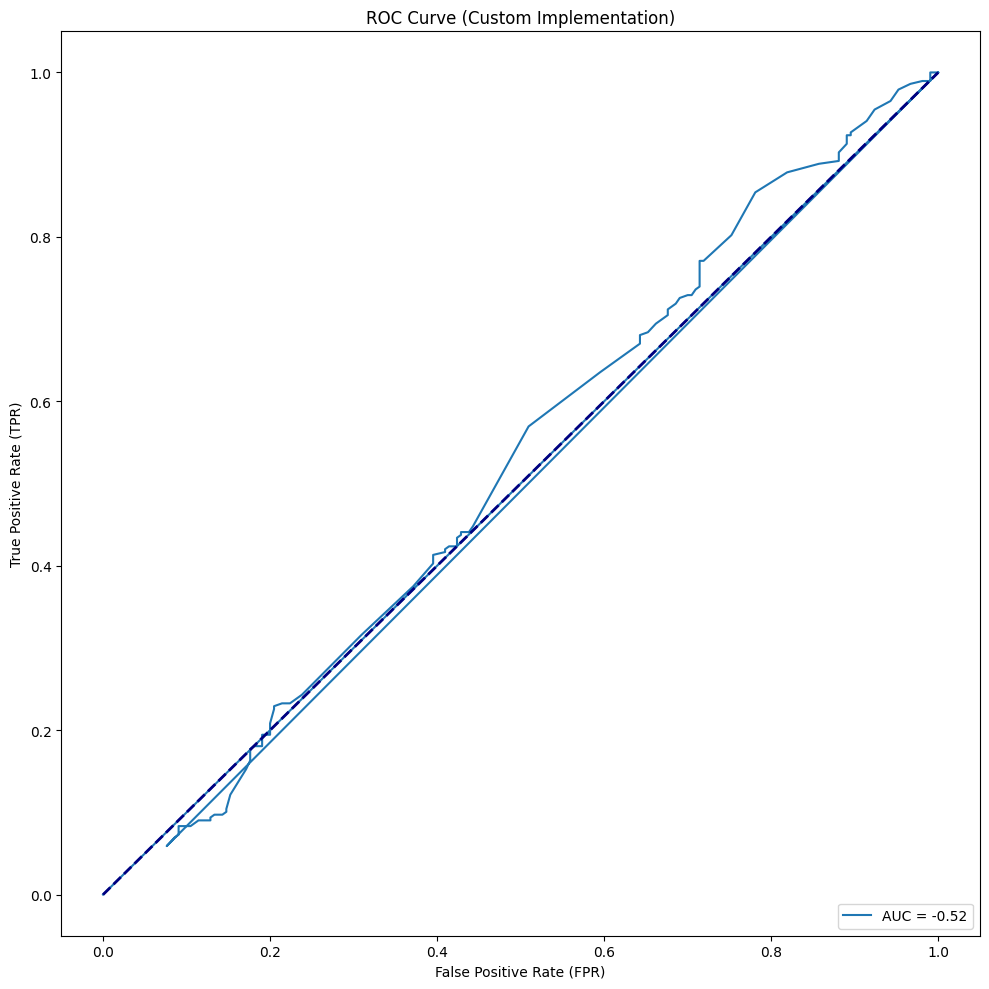

In [718]:
thresholds_tp, thresholds_tn, thresholds_fp, thresholds_fn = confusion_matrix(result_df['DT_pred'], result_df['survival'])
print(thresholds_tp, thresholds_tn, thresholds_fp, thresholds_fn)
roc_fpr, roc_tpr, thresholds, auc_value = roc_curve_scratch(result_df['survival'], result_df['DT_pred'], result_df['test'])
def roc_curve_graph(roc_fpr, roc_tpr, auc_value, save_path='roc_curves.jpg'):
    plt.figure(figsize=(10, 10))
    plt.plot(roc_fpr, roc_tpr, label=f'AUC = {auc_value:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('ROC Curve (Custom Implementation)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(save_path, format='jpg', bbox_inches='tight', pad_inches=0)
    plt.show()
roc_curve_graph(roc_fpr, roc_tpr, auc_value)

0 0 0 0


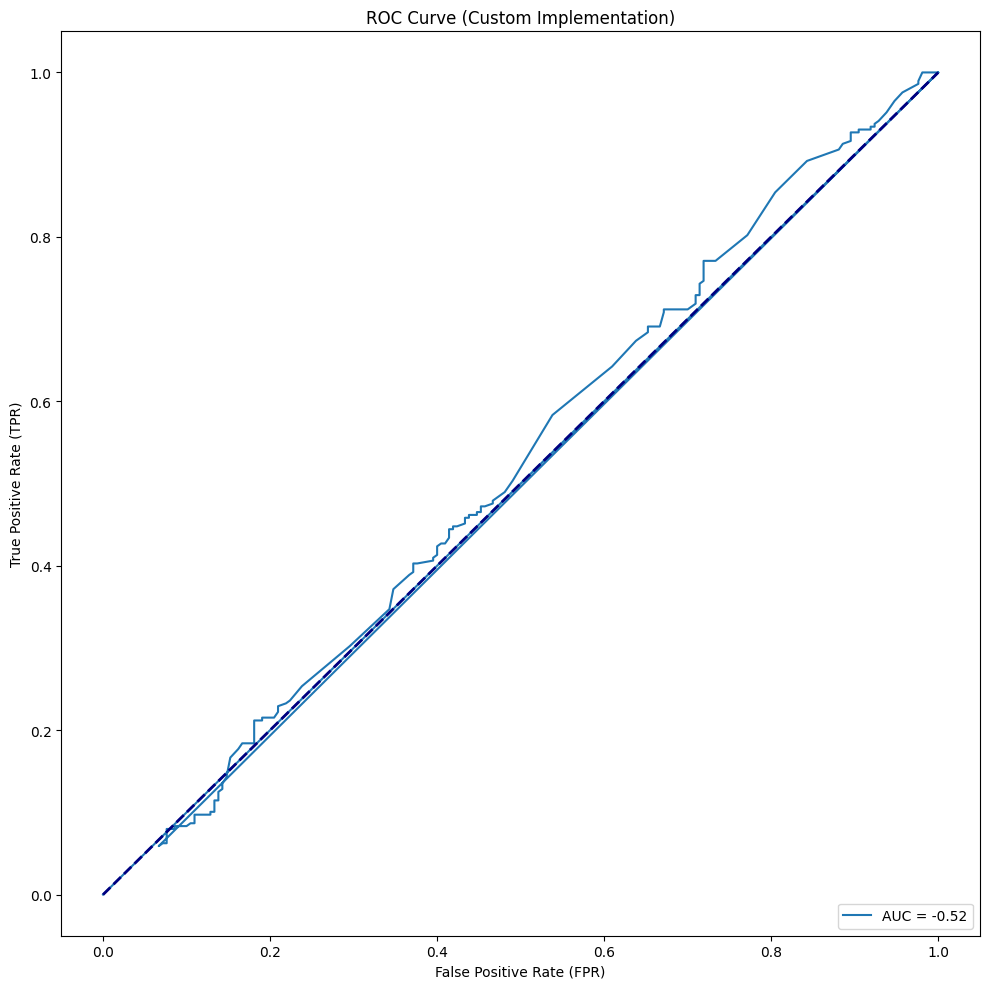

In [719]:
thresholds_tp, thresholds_tn, thresholds_fp, thresholds_fn = confusion_matrix(result_df['RF_pred'], result_df['survival'])
print(thresholds_tp, thresholds_tn, thresholds_fp, thresholds_fn)
roc_fpr, roc_tpr, thresholds, auc_value = roc_curve_scratch(result_df['survival'], result_df['RF_pred'], result_df['test'])
def roc_curve_graph(roc_fpr, roc_tpr, auc_value, save_path='roc_curves.jpg'):
    plt.figure(figsize=(10, 10))
    plt.plot(roc_fpr, roc_tpr, label=f'AUC = {auc_value:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('ROC Curve (Custom Implementation)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(save_path, format='jpg', bbox_inches='tight', pad_inches=0)
    plt.show()
roc_curve_graph(roc_fpr, roc_tpr, auc_value)

In [720]:
# roc_fpr, roc_tpr, thresholds, auc_value = roc_curve_scratch(result_df['LR_pred'], result_df['survival'])

In [721]:
number_of_classes = len(result_df['test'].unique())
conf_matrix = my_confusion_matrix(result_df['test'], result_df['LR_pred'], number_of_classes)
print(conf_matrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [722]:
evaluation_results = metrics(conf_matrix)
df_results = pd.DataFrame.from_dict(evaluation_results, orient='index')
print(df_results)

           TP  TN  FP  FN  Total  Positives  Negatives  Sensitivity(Recall)  \
Class 0     0   0   0   0      0          0          0                    0   
Class 1     0   0   0   0      0          0          0                    0   
Class 2     0   0   0   0      0          0          0                    0   
Class 3     0   0   0   0      0          0          0                    0   
Class 4     0   0   0   0      0          0          0                    0   
...        ..  ..  ..  ..    ...        ...        ...                  ...   
Class 207   0   0   0   0      0          0          0                    0   
Class 208   0   0   0   0      0          0          0                    0   
Class 209   0   0   0   0      0          0          0                    0   
Class 210   0   0   0   0      0          0          0                    0   
Class 211   0   0   0   0      0          0          0                    0   

           Specificity  Precision  
Class 0        